In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from model_linear import Autoencoder
from custom_dataset import CustomDataset
from torchvision.transforms.functional import normalize
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = ("cuda:1" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder(16).to(device)

# ## Data Parallelism
# if torch.cuda.is_available() and torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs for Data Parallelism!")
#     autoencoder = nn.DataParallel(Autoencoder().to(device))
# else:
#     autoencoder = Autoencoder().to(device)

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])
batch_size = 1024
train_dataset = CustomDataset(data_path='/mayo_atlas/home/m296984/MAIN_CHAIN_CRC_RESULTS/train_16x16_patches', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [3]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

Epoch [1/10], Batch [0/915], Loss: 0.2531
Epoch [1/10], Batch [500/915], Loss: 0.1023


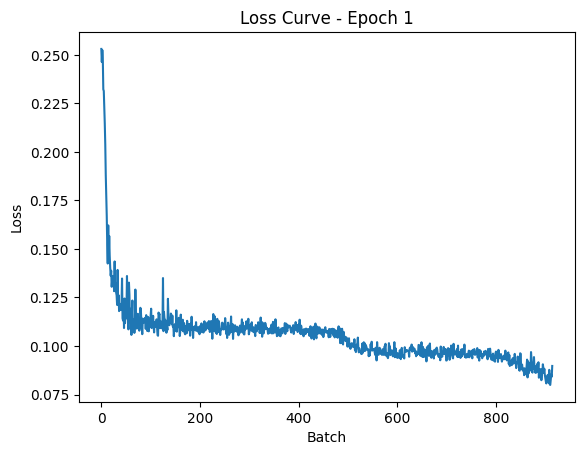

Epoch [2/10], Batch [0/915], Loss: 0.0837
Epoch [2/10], Batch [500/915], Loss: 0.0767


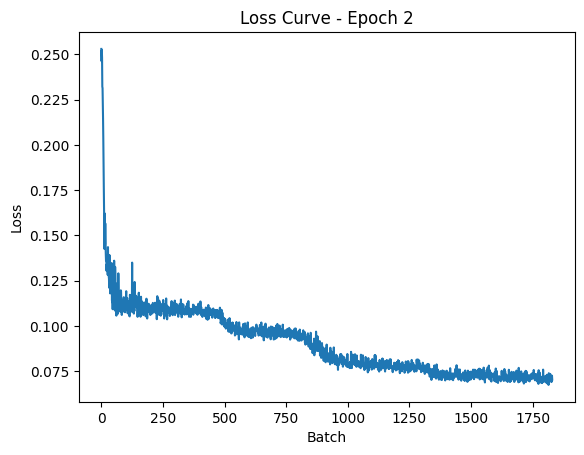

Epoch [3/10], Batch [0/915], Loss: 0.0694
Epoch [3/10], Batch [500/915], Loss: 0.0650


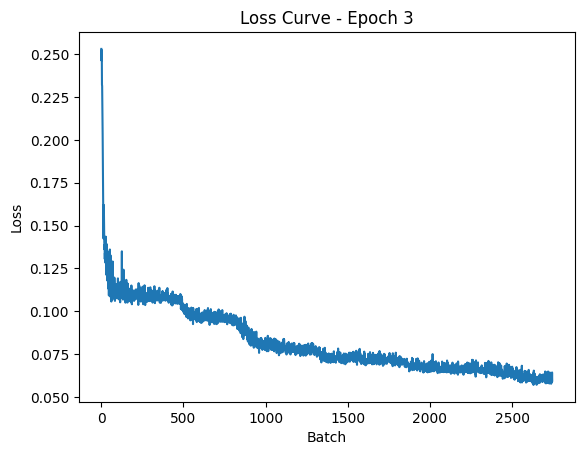

Epoch [4/10], Batch [0/915], Loss: 0.0638
Epoch [4/10], Batch [500/915], Loss: 0.0567


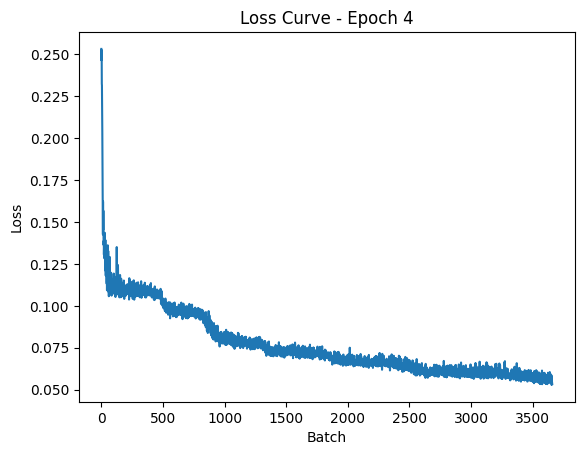

Epoch [5/10], Batch [0/915], Loss: 0.0550
Epoch [5/10], Batch [500/915], Loss: 0.0586


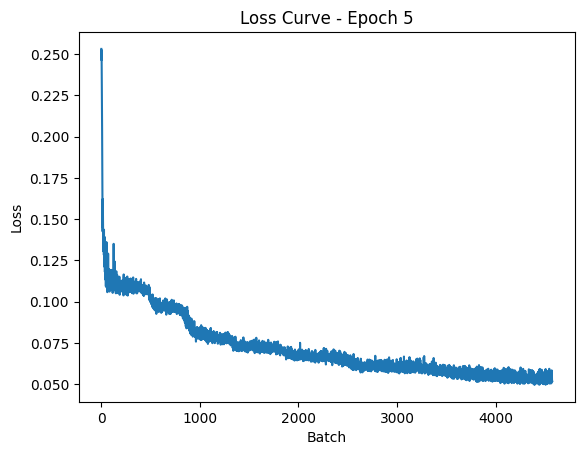

Epoch [6/10], Batch [0/915], Loss: 0.0530
Epoch [6/10], Batch [500/915], Loss: 0.0500


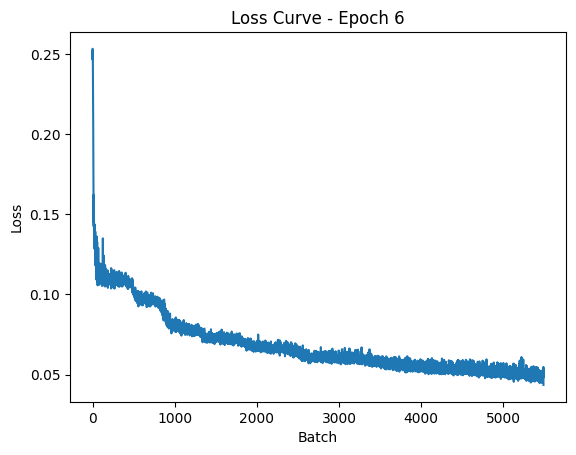

Epoch [7/10], Batch [0/915], Loss: 0.0516
Epoch [7/10], Batch [500/915], Loss: 0.0479


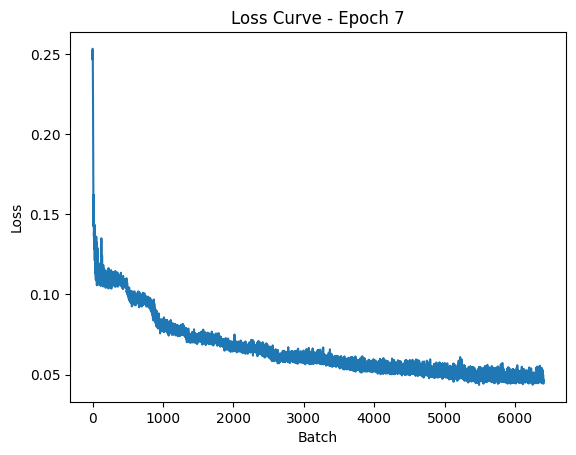

Epoch [8/10], Batch [0/915], Loss: 0.0457
Epoch [8/10], Batch [500/915], Loss: 0.0467


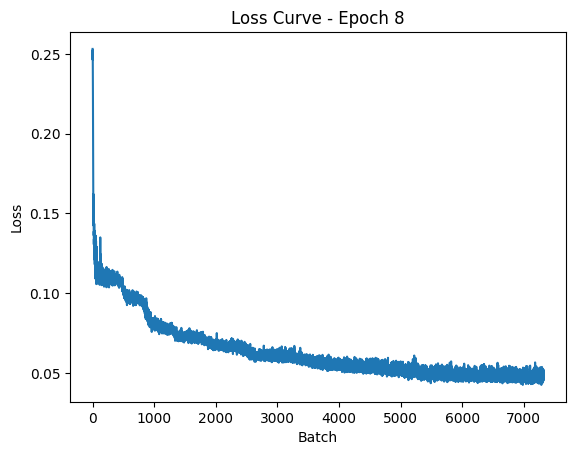

Epoch [9/10], Batch [0/915], Loss: 0.0461
Epoch [9/10], Batch [500/915], Loss: 0.0454


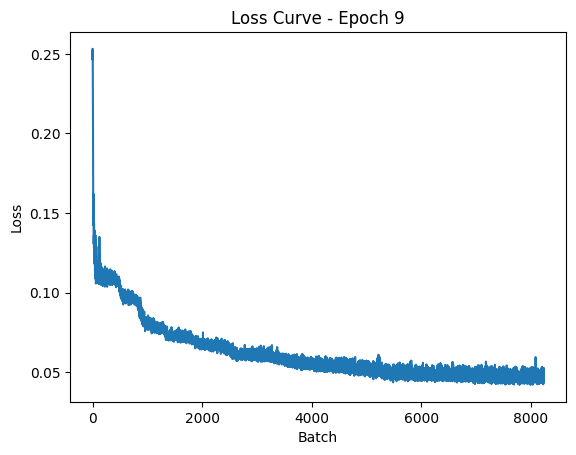

Epoch [10/10], Batch [0/915], Loss: 0.0467
Epoch [10/10], Batch [500/915], Loss: 0.0448


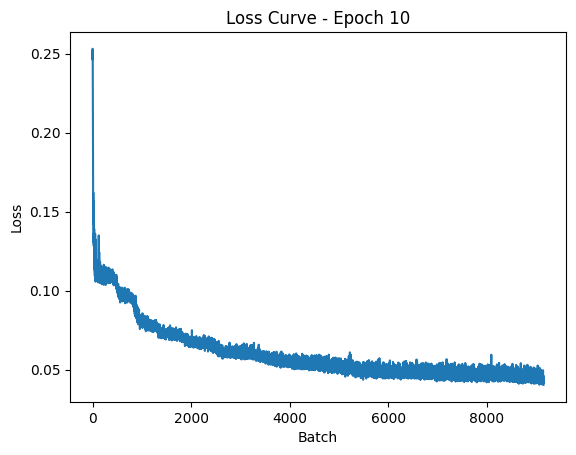

In [4]:
# Training loop for masking
def random_mask(img_data, device):
    # Generate a binary mask with a random percentage of values set to 1
    mask_percentage = np.random.uniform(0.1, 0.75)
    #Masking should possibly be 2D
    mask = torch.rand(img_data.shape, device=device) < mask_percentage
    # Apply the mask to the random_image to replace values with -1000
    dummy_value = 0
    masked_image = torch.where(mask, dummy_value, img_data)
    return masked_image


num_epochs = 10
losses = []  # List to store loss values

for epoch in range(num_epochs):
    for batch_idx, (images, _) in enumerate(train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        masked_images = random_mask(images, device)
        
        # Forward pass
        _, outputs = autoencoder(masked_images)
        loss = criterion(outputs, images)
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        # Store loss value
        losses.append(loss.item())
        
        if batch_idx % 500 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")
            
            # Visualize original, masked, and reconstructed images
            with torch.no_grad():
                autoencoder.eval()
                test_images, _ = next(iter(train_loader))
                test_images = test_images.to(device)
                masked_images = random_mask(test_images, device)
                _, reconstructed = autoencoder(test_images)
                autoencoder.train()
                
                plt.figure(figsize=(15, 6))
                for i in range(5):
                    plt.subplot(3, 5, i + 1)
                    plt.imshow((test_images[i].permute(1, 2, 0).cpu().numpy() * 0.5) + 0.5)
                    plt.title("Original")
                    plt.axis('off')

                    plt.subplot(3, 5, i + 6)
                    plt.imshow((masked_images[i].permute(1, 2, 0).cpu().numpy() * 0.5) + 0.5)
                    plt.title("Masked")
                    plt.axis('off')
                    
                    plt.subplot(3, 5, i + 11)
                    plt.imshow((reconstructed[i].permute(1, 2, 0).cpu().numpy() * 0.5) + 0.5)
                    plt.title("Reconstructed")
                    plt.axis('off')
                
                plt.tight_layout()
                plt.savefig(f"/home/m296984/MAIN_CHAIN/NEW_VAE_IMAGES/epoch_{epoch}_visualization_batch_{batch_idx}.png")
                plt.close()  # Close the figure to release memory
                
    torch.save(autoencoder.state_dict(), f"/home/m296984/MAIN_CHAIN/NEW_VAE_MODELS/autoencoder_epoch_{epoch}.pth")
    # Plot loss curve
    plt.plot(losses)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve - Epoch {epoch+1}")
    plt.show()

In [5]:
# # Training loop for no masking
# num_epochs = 10
# losses = []  # List to store loss values

# for epoch in range(num_epochs):
#     for batch_idx, (images, _) in enumerate(train_loader):
#         optimizer.zero_grad()
#         images = images.to(device)
 
#         # Forward pass
#         _, outputs = autoencoder(images)
#         loss = criterion(outputs, images)
        
#         # Backpropagation and optimization
#         loss.backward()
#         optimizer.step()
        
#         # Store loss value
#         losses.append(loss.item())
        
#         if batch_idx % 250 == 0:
#             print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")
            
#             # Visualize reconstructed images
#             with torch.no_grad():
#                 autoencoder.eval()
#                 test_images, _ = next(iter(train_loader))
#                 test_images = test_images.to(device)
#                 _, reconstructed = autoencoder(test_images)
#                 autoencoder.train()
                
#                 # Plot original images
#                 plt.figure(figsize=(10, 4))
#                 for i in range(5):
#                     plt.subplot(2, 5, i + 1)
#                     plt.imshow((test_images[i].permute(1, 2, 0).cpu().numpy() * 0.5) + 0.5)
#                     plt.title("Original")
#                     plt.axis('off')

#                     plt.subplot(2, 5, i + 6)
#                     plt.imshow((reconstructed[i].permute(1, 2, 0).cpu().numpy() * 0.5) + 0.5)
#                     plt.title("Reconstructed")
#                     plt.axis('off')
#                 plt.savefig(f"/home/m296984/MAIN_CHAIN/NEW_VAE_IMAGES/epoch_{epoch}_visualization_batch_{batch_idx}.png")
#                 plt.close()  # Close the figure to release memory
                
#     torch.save(autoencoder.state_dict(), f"/home/m296984/MAIN_CHAIN/NEW_VAE_MODELS/autoencoder_epoch_{epoch}.pth")
#     # Plot loss curve
#     plt.plot(losses)
#     plt.xlabel("Batch")
#     plt.ylabel("Loss")
#     plt.title(f"Loss Curve")
#     plt.show()